In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
from Data import get_setup
from Inference_new import *
from Models.VI import *
from Tools import uniform_rect_sampler

In [3]:
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [14]:
dataset='concrete'
seed=117
setup_ = get_setup(dataset)
setup = setup_.Setup(device, seed=seed)
x_train, y_train = setup.train_data()

input_dim = x_train.shape[1]
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)

std_y_train = torch.tensor(setup.scaler_y.scale_, device=device).squeeze().float()
sigma_noise=setup.sigma_noise

In [15]:
nb_input_samples = 500
n_epochs = 2000
num_epochs_ensemble = 500
batch_size = 500
patience=20
# predictive model architecture
layerwidth = 100
nblayers = 1
activation = nn.ReLU()
lat_dim=10
n_samples_VAR = 50


In [16]:
input_sampler = uniform_rect_sampler(x_train, n=nb_input_samples)

model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=sigma_noise, learn_noise=False,
             lat_dim=lat_dim).to(device)
logs, run_time = FuNN_train(model, train_dataset, batch_size, input_sampler, n_epochs=n_epochs,
                        patience=patience)

FuNN-HyVI:  26%|██▌       | 522/2000 [00:58<02:45,  8.96it/s, ELBO=1.14e+3, KL=20.2, LogLike=-1.13e+3, lr=0.0001, sigma=4.5]  


# Logs

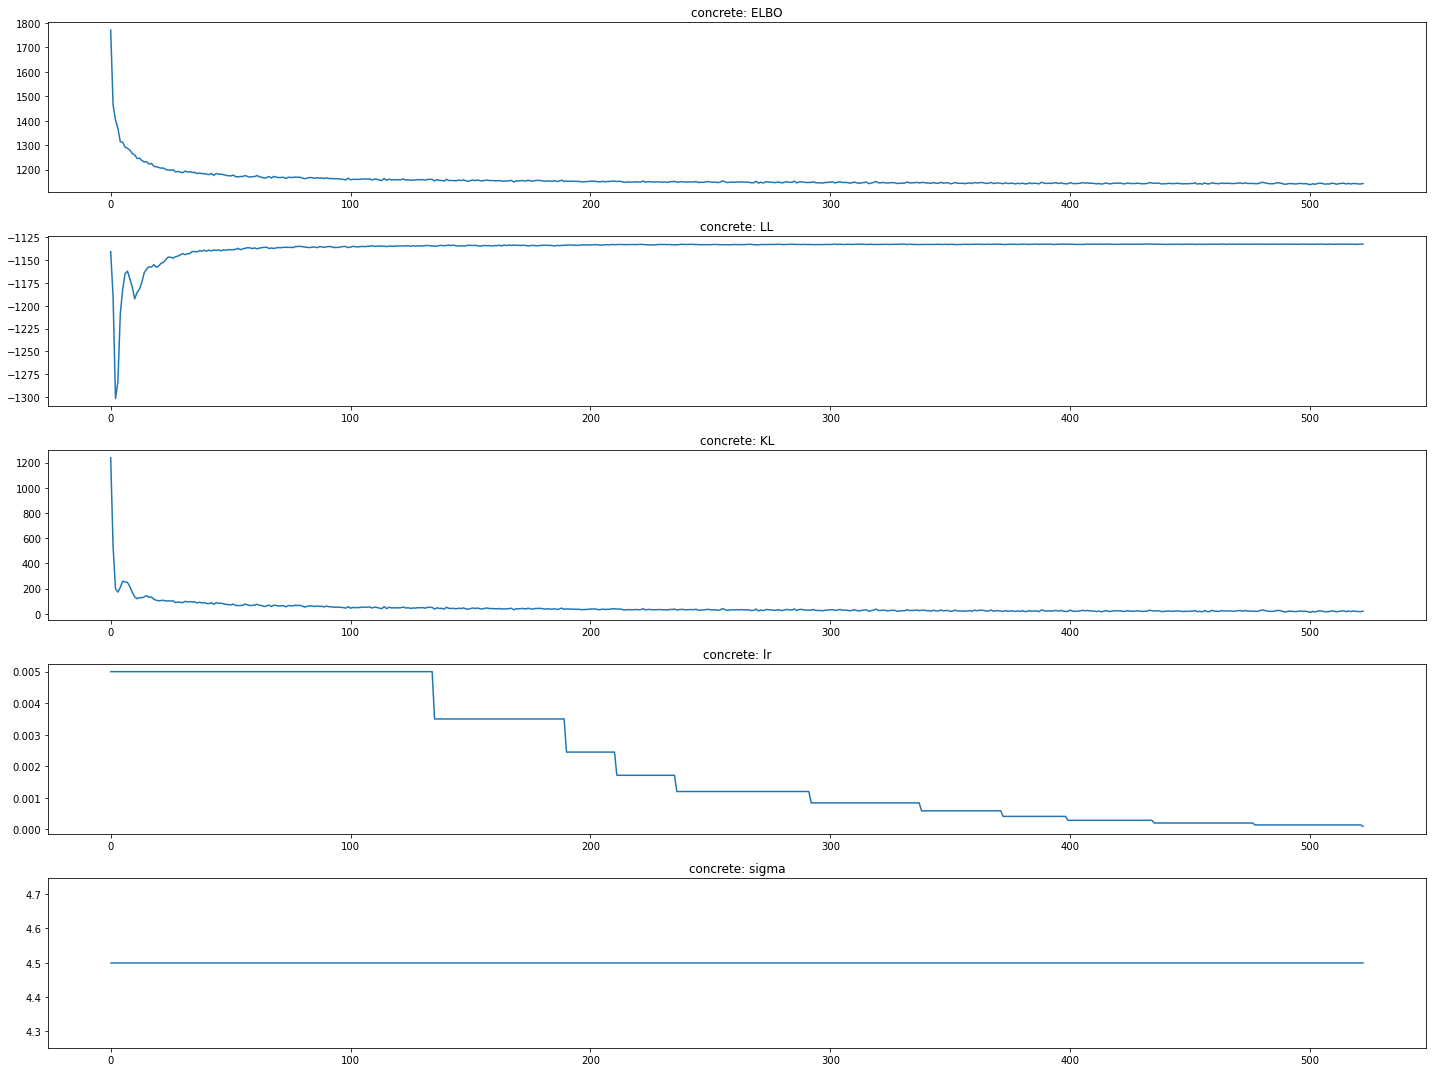

In [17]:

from pylab import *
fig, ax=plt.subplots(5, 1, figsize=(20,15))
ax=ax.flatten()
i=0
for key in logs.keys():
    ax[i].plot(range(len(logs[key])), logs[key])
    ax[i].set_title(dataset+': '+key)
    i+=1

fig.tight_layout()

# Results on test data

In [30]:
from Metrics import rmse, lpp, lpp_gaussian
def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

x_test, y_test = setup.test_data()

y_pred=model(x_test,5)
metrics=get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, run_time)
for key, value in metrics.items():
    print(key+": {:.4f}".format(value))

RMSE: 6.9391
LPP: -5.2438
time [s]: 58.2774
std noise: 4.5000


# Entropy of posterior distribution

In [31]:
from Metrics import entropy_nne
def FunH(model, sampler, n=100, n_MC=200):
    Hs=[entropy_nne(model(sampler()).squeeze(2), k=1, k_MC=n_MC).item() for _ in range(n)]
    return np.mean(Hs)
nb_predictors=1000
n_MC=200
OOD_sampler = uniform_rect_sampler(x_train, n=n_MC)

method="FuNN-HyVI"
print("Posterior entropy in parameter space: {:.2f}".format(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item()))
print("Posterior entropy in function space: {:.2f}".format(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200)))


Posterior entropy in parameter space: -750.77
Posterior entropy in function space: 123.19


# OOD detection

In [42]:
n_ood=10000
OOD_sampler = uniform_rect_sampler(x_train, n=n_ood) 
x_OOD=OOD_sampler() 
        
X = [x_train, x_test, x_OOD]
data_type=['train','test','OOD']

In [43]:
def VAR(model, X):
    return [torch.cat([model(x_, 1000).detach().std(0).squeeze() for x_ in x.split(500,dim=0)],dim=0) for x in X]


In [44]:
V=VAR(model,X)

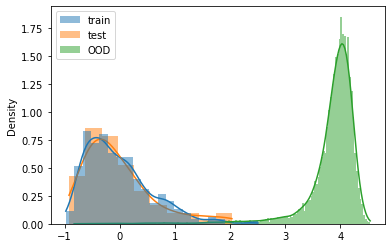

In [51]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap
cmap=ListedColormap(sns.color_palette("tab10").as_hex())

fig,ax=plt.subplots()
for i in range(len(V)):
    sns.histplot(0.5*torch.log(2*math.pi*math.e*V[i]**2).cpu(), stat='density', lw=0,alpha = .5, 
                 kde=True, color=cmap(i), label=data_type[i],zorder=3-i, ax=ax)
ax.legend(loc='best')

Text(0.5, 1.0, 'AUC: 0.9976')

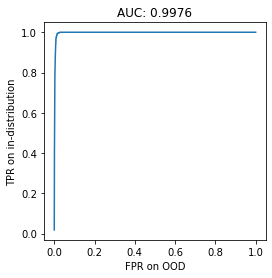

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr=torch.arange(n_ood).true_divide(n_ood)

H_in=torch.cat([V[0],V[1]]).cpu()
H_ood, _=V[2].cpu().sort()

tpr=(H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in))
y_true=torch.cat([torch.ones_like(H_in),torch.zeros_like(H_ood)])
y_score=-torch.cat([H_in,H_ood])
AUC=roc_auc_score(y_true.cpu(), y_score.cpu())

fig, ax=plt.subplots()

ax.plot(fpr, tpr, alpha=1)
ax.set_aspect('equal')
ax.set_xlabel('FPR on OOD')
ax.set_ylabel('TPR on in-distribution')
ax.set_title('AUC: {:.4f}'.format(AUC))